# Final Project <a id='intro'></a>

## Project Description
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

## Interconnect's Services
Interconnect mainly provides two types of services:
1) Landline communication. The telephone can be connected to several lines simultaneously.
2) Internet. The network can be set up via a telephone line (DSL, _digital subscriber line_) or through a fiber optic cable.

Some other services the company provides include:
- Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
- A dedicated technical support line (TechSupport)
- Cloud file storage and data backup (OnlineBackup)
- TV streaming (StreamingTV) and a movie directory (StreamingMovies)
The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

## Data Description
The data consists of files obtained from different sources:
- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column **customerID** contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

## Work Plan
**A) Initialization:** Import necessary libraries such as Pandas, NumPy, Matplotlib, Seaborn for data manipulation and visualization, and Scikit-learn for model building.

**B) Load Data:** Load all four CSV files (`contract.csv`, `personal.csv`, `internet.csv`, `phone.csv`) into separate DataFrames. Ensure that the data types are appropriate for analysis.

**C) Data Preprocessing:**
- Check for missing values and fill or drop them as necessary.
- Identify and remove duplicate rows.
- Convert any inappropriate data types to the correct format (e.g., dates, categorical variables).

**D) Exploratory Data Analysis:**
- Use visualizations (bar plots, histograms, box plots) to identify trends and relationships between customer attributes and churn rates.
- Look for correlations between features and the target variable.

**E) Model Training Preparation:**
- Split the dataset into training, validation and test sets.
- Encode categorical variables using techniques like one-hot encoding or label encoding as appropriate.
- Handle class imbalance through appropriate means.

**F) Model Training:**
- Select a variety of classification algorithms (e.g., Logistic Regression, Random Forest, Gradient Boosting).
- Use cross-validation to tune hyperparameters and select the best-performing model based on the AUC-ROC score.

**G) Model Analysis & Test:**
- Analyze the performance of each model using AUC-ROC and accuracy metrics.
- Choose the best model and retrain it on the entire training set, then evaluate it on the test set.

## Clarifying Questions
1) What is the most appropriate way to address missing values—should they be filled with a specific value (e.g., "No," -1) or should rows be removed?

2) Are there specific features that require in-depth exploratory analysis? Which features should we prioritize in our analysis?

3) What strategies should we consider for addressing potential class imbalance between churned and non-churned customers (e.g., oversampling, undersampling, or using different evaluation metrics)?

4) Do you have any recommendations on specific models that have been successful in similar churn prediction tasks?

5) Are there any specific feature engineering techniques you recommend to enhance the predictive power of the model?

## Initialization

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

## Load Data

In [2]:
# Load data function
def load_data(file_name, local_path, server_path):
    try:
        data = pd.read_csv(local_path + file_name)
        print(f"'{file_name}' file successfully read from the local path.")

    except FileNotFoundError:
        try:
            data = pd.read_csv(server_path + file_name)
            print(f"'{file_name}' file successfully read from the server path.")

        except FileNotFoundError:
            print(f"'{file_name}' file not found. Please check the file paths.")
            data = None
            
    return data

file_names = ['contract.csv', 'internet.csv', 'personal.csv', 'phone.csv']
local_path = '/Users/benjaminstephen/Documents/TripleTen/Sprint_17/Final_Project/datasets/final_provider/'
server_path = '/datasets/final_provider/'

contract_data = load_data(file_names[0], local_path, server_path)
internet_data = load_data(file_names[1], local_path, server_path)
personal_data = load_data(file_names[2], local_path, server_path)   
phone_data = load_data(file_names[3], local_path, server_path)  

'contract.csv' file successfully read from the local path.
'internet.csv' file successfully read from the local path.
'personal.csv' file successfully read from the local path.
'phone.csv' file successfully read from the local path.


## Data Preprocessing

To start, we will preprocess the data and clean it to ensure it is optimally prepared for model training. We will be utilizing the fucntion below to help us observe the data in a timely manner.

In [3]:
# Analyze function
def analyze(data):
    # Display the DataFrame
    display(data)

    # Print DataFrame Info
    print("DATAFRAME INFO:")
    data.info()
    print()

    # Calculate Percentage of Null Values
    print("PERCENTAGE OF NULL VALUES:")
    print((data.isnull().sum()/len(data)) * 100)
    print()

    # Calculate Number of Duplicated Rows
    print("NUMBER OF DUPLICATED ROWS:", data.duplicated().sum())

### Contract Data

In [4]:
analyze(contract_data)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

PERCENTAGE OF NULL VALUES:
customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: float64

NUMBER OF DUPLICATED ROWS: 0


The Contract Data appears to be in good shape, with no missing values or duplicates. However, certain feature columns could be optimized by updating their data types. For example, the BeginDate and EndDate columns, which are currently of the object data type, should be converted to datetime format for better date manipulation. Similarly, the TotalCharges column would be more effective as a float to allow for accurate numerical computations.

Let's convert the BeginDate column into the datetime data type.

In [5]:
contract_data['BeginDate'] = pd.to_datetime(contract_data['BeginDate'], format='%Y-%m-%d')

print(contract_data['BeginDate'].dtype)

datetime64[ns]


We will now convert the EndDate column. Since we know that the contract information is valid as of February 1, 2020, all entries labeled as 'No' in this column will be updated to reflect this date.

In [6]:
contract_data['EndDate'] = contract_data['EndDate'].replace('No', '2020-02-01 00:00:00')
contract_data['EndDate'] = pd.to_datetime(contract_data['EndDate'], format='%Y-%m-%d')

print(contract_data['EndDate'].dtype)

datetime64[ns]


And we will convert the TotalCharges column into the float data type.

In [7]:
contract_data['TotalCharges'] = pd.to_numeric(contract_data['TotalCharges'], errors='coerce')
contract_data['TotalCharges'] = contract_data['TotalCharges'].fillna(0)

print(contract_data['TotalCharges'].dtype)

float64


To ensure the integrity of the Contract Data, we will analyze the number of unique values within each column. This examination will help us confirm that all values are appropriate and consistent.

In [8]:
print(contract_data.nunique())

customerID          7043
BeginDate             77
EndDate                5
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
dtype: int64


We observe that there are 7,043 unique customerIDs, which aligns perfectly with the total of 7,043 entries in the Contract Data. I am particularly interested in examining the values within the EndDate, Type, PaperlessBilling, and MonthlyCharges columns. Since these columns contain a limited number of unique values, they will be straightforward to explore

In [9]:
print("EndDate:")
print(contract_data['EndDate'].value_counts())
print()
print("Type:")
print(contract_data['Type'].value_counts())
print()
print("PaperlessBilling:")
print(contract_data['PaperlessBilling'].value_counts())
print()
print("PaymentMethod:")
print(contract_data['PaymentMethod'].value_counts())


EndDate:
2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: EndDate, dtype: int64

Type:
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

PaperlessBilling:
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

PaymentMethod:
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64


In [10]:
# Rename certain values in the PaymentMethod column for simplicity
contract_data['PaymentMethod'] = contract_data['PaymentMethod'].replace('Bank transfer (automatic)', 'Bank transfer')
contract_data['PaymentMethod'] = contract_data['PaymentMethod'].replace('Credit card (automatic)', 'Credit card')

print(contract_data['PaymentMethod'].value_counts())

Electronic check    2365
Mailed check        1612
Bank transfer       1544
Credit card         1522
Name: PaymentMethod, dtype: int64


The values in the aforementioned columns appear logical and appropriate, confirming that the data is robust and reliable for analysis in these specific areas.

Now, let’s examine the BeginDate column to ensure that the values are appropriate. We will plot the distribution of dates to facilitate this analysis.

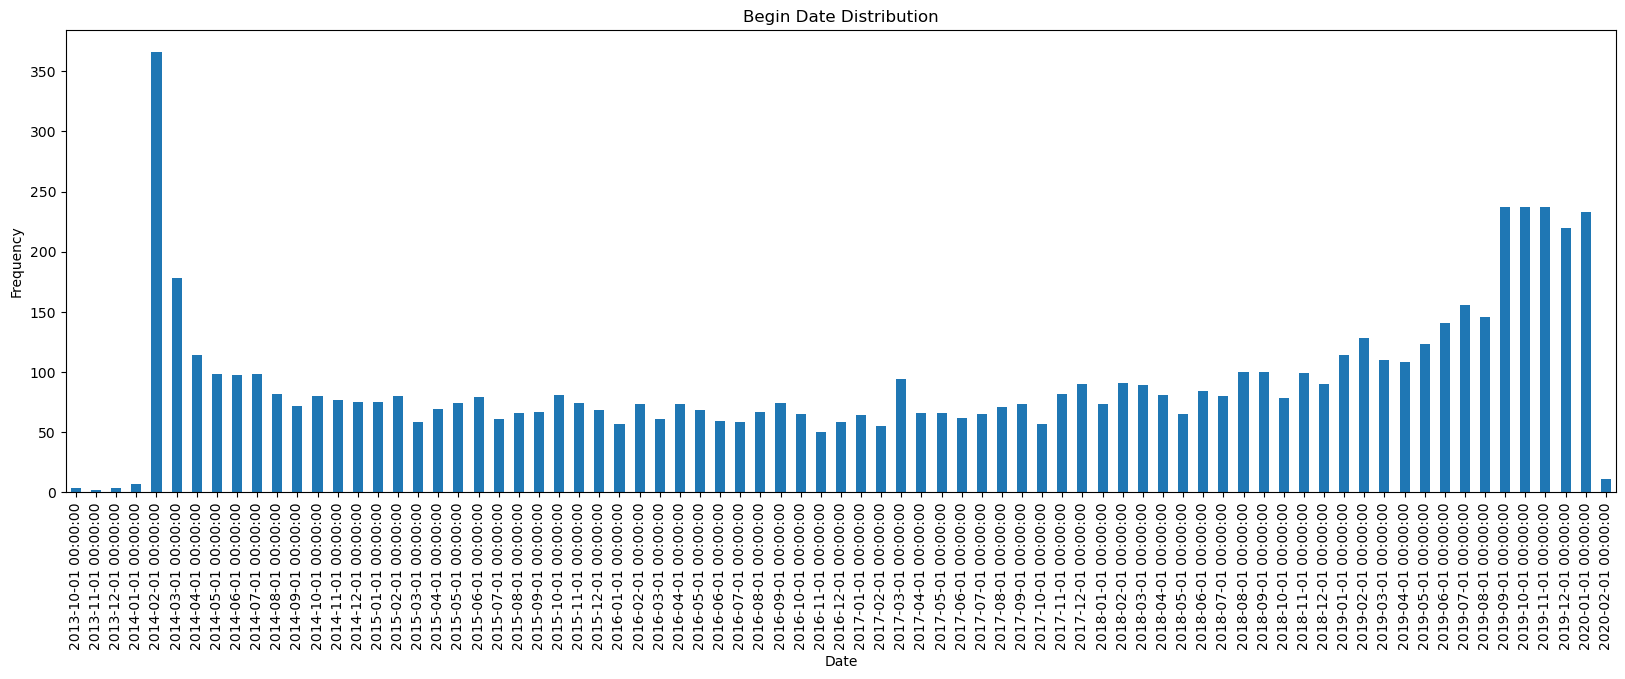

In [11]:
# Set the figure size
plt.figure(figsize=(20, 6))

# Plotting BeginDate
contract_data['BeginDate'].value_counts().sort_index().plot(kind='bar')
plt.title('Begin Date Distribution')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

# Show the plot
plt.show()

As illustrated in the graph above, the range of date distributions appears to be appropriate, with all dates falling between October 1, 2013, and February 1, 2020.

In [12]:
print(contract_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB
None


The Contract Data has been successfully preprocessed.

### Internet Data

In [13]:
analyze(internet_data)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

PERCENTAGE OF NULL VALUES:
customerID          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64

NUMBER OF DUPLICATED ROWS: 0


The Internet Data appears to be in good condition, with all columns having the appropriate data types and no null values or duplicate rows present.

Aside from the customerID column, we can reasonably assume that the remaining columns contain only 'Yes' or 'No' values. To validate this assumption, let’s examine the number of unique values within the DataFrame.

In [14]:
print(internet_data.nunique())

customerID          5517
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
dtype: int64


The customerID column contains 5,517 unique values, which aligns perfectly with the 5,517 entries in this specific DataFrame. Additionally, the remaining columns each contain exactly two distinct values.

The Internet Data has been successfully preprocessed.

### Personal Data

In [15]:
analyze(personal_data)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

PERCENTAGE OF NULL VALUES:
customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64

NUMBER OF DUPLICATED ROWS: 0


The Personal Data is in good condition, with no null values or duplicate rows. However, I would like to modify the values in the SeniorCitizen feature, which currently uses 1s and 0s to indicate "Yes" or "No," respectively. To ensure consistency with the rest of the dataset, I propose changing these values to align with the format used in other columns.

Before making this adjustment, let's analyze the distribution of 1s and 0s in the column. We can reasonably assume that the majority of customers are not senior citizens, so we will examine the distribution of these values and assign 0 to the category with the highest representation.

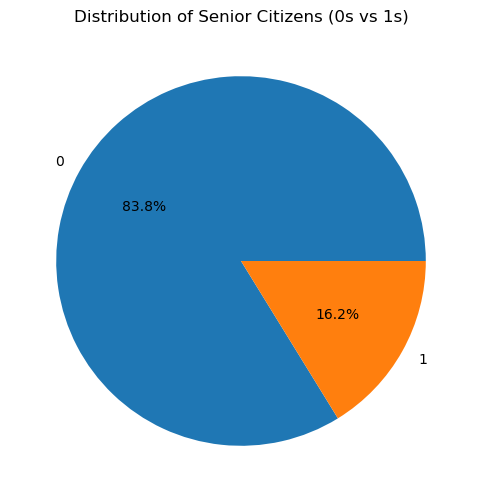

In [16]:
# Count the occurrences of each class in the SeniorCitizen column
sc_value_counts = personal_data['SeniorCitizen'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(sc_value_counts, labels=sc_value_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Senior Citizens (0s vs 1s)')
plt.show()

The pie chart illustrates the distribution of 0s and 1s in the SeniorCitizen column, revealing that 83.8% of the entries correspond to 0, while 16.2% represent 1. We can assume that the majority of the population consists of non-senior citizens. Therefore, we can associate the 0s with non-senior citizens for further analysis.

In [17]:
personal_data['SeniorCitizen'] = personal_data['SeniorCitizen'].map({1: 'Yes', 0: 'No'})

Now, let’s examine the number of unique values within this dataset. Aside from the customerID column, we can anticipate that each feature column will contain only two unique values.

In [18]:
print(personal_data.nunique())

customerID       7043
gender              2
SeniorCitizen       2
Partner             2
Dependents          2
dtype: int64


Our assumptions are correct. The feature columns only contain "Yes" or "No" values.

In [19]:
# Rename 'gender' column to "Gender" to follow consistent naming convention
personal_data = personal_data.rename(columns={'gender': 'Gender'})

print(personal_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   Gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB
None


The Personal Data has been successfully preprocessed.

### Phone Data

In [20]:
analyze(phone_data)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

PERCENTAGE OF NULL VALUES:
customerID       0.0
MultipleLines    0.0
dtype: float64

NUMBER OF DUPLICATED ROWS: 0


The Phone Data is in good condition, with no null values or duplicate rows detected.

To further validate the quality of the data, let’s examine the number of unique values in each column.

In [21]:
print(phone_data.nunique())

customerID       6361
MultipleLines       2
dtype: int64


The Phone Data has been successfully preprocessed.

### Merged Data

With all the dataframes individually preprocessed, we can now proceed to merge them into a Master DataFrame, providing a more comprehensive view of the data.

In [22]:
# List of DataFrames to merge
dfs = [contract_data, internet_data, personal_data, phone_data]

# Merge all DataFrames on 'customer_id'
df = reduce(lambda left, right: pd.merge(left, right, on='customerID', how='outer'), dfs)

analyze(df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,No,Yes,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer,42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,No,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,DSL,Yes,No,Yes,Yes,Yes,Yes,Male,No,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card,103.20,7362.90,Fiber optic,No,Yes,Yes,No,Yes,Yes,Female,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,Female,No,Yes,Yes,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,Fiber optic,No,No,No,No,No,No,Male,Yes,Yes,No,Yes


DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  Streamin

After merging the data, we identified some missing values across several columns. Approximately 21.67% of the data is missing from the Internet-related columns, which we will fill with 'No'. 

Additionally, we will fill the 9.68% of missing data in the MultipleLines column with 'No' as well.

In [23]:
df = df.replace(np.nan, 'No')

We can further enhance the Master DataFrame by creating a target column called Churned, which will indicate whether or not a client has churned. This will be based on observations where the EndDate is '2020-02-01.'

In [24]:
churned = (df['EndDate'] != '2020-02-01').astype(int)
df.insert(1, 'Churned', churned)

# Replace numerical values in the Churned column with corresponding labels for better readability
df['Churned'] = df['Churned'].replace(0, 'No')
df['Churned'] = df['Churned'].replace(1, 'Yes')

We will also introduce a feature called Duration(Days), which will indicate how many days a client has remained on the plan.

In [25]:
duration = (df['EndDate'] - df['BeginDate']).dt.days
df.insert(4, 'Duration(Days)', duration)

analyze(df)

,customerID,Churned,BeginDate,EndDate,Duration(Days),Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,No,2020-01-01,2020-02-01,31,Month-to-month,Yes,Electronic check,29.85,29.85,...,Yes,No,No,No,No,Female,No,Yes,No,No
1,5575-GNVDE,No,2017-04-01,2020-02-01,1036,One year,No,Mailed check,56.95,1889.50,...,No,Yes,No,No,No,Male,No,No,No,No
2,3668-QPYBK,Yes,2019-10-01,2019-12-01,61,Month-to-month,Yes,Mailed check,53.85,108.15,...,Yes,No,No,No,No,Male,No,No,No,No
3,7795-CFOCW,No,2016-05-01,2020-02-01,1371,One year,No,Bank transfer,42.30,1840.75,...,No,Yes,Yes,No,No,Male,No,No,No,No
4,9237-HQITU,Yes,2019-09-01,2019-11-01,61,Month-to-month,Yes,Electronic check,70.70,151.65,...,No,No,No,No,No,Female,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,No,2018-02-01,2020-02-01,730,One year,Yes,Mailed check,84.80,1990.50,...,No,Yes,Yes,Yes,Yes,Male,No,Yes,Yes,Yes
7039,2234-XADUH,No,2014-02-01,2020-02-01,2191,One year,Yes,Credit card,103.20,7362.90,...,Yes,Yes,No,Yes,Yes,Female,No,Yes,Yes,Yes
7040,4801-JZAZL,No,2019-03-01,2020-02-01,337,Month-to-month,Yes,Electronic check,29.60,346.45,...,No,No,No,No,No,Female,No,Yes,Yes,No
7041,8361-LTMKD,Yes,2019-07-01,2019-11-01,123,Month-to-month,Yes,Mailed check,74.40,306.60,...,No,No,No,No,No,Male,Yes,Yes,No,Yes


DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   Churned           7043 non-null   object        
 2   BeginDate         7043 non-null   datetime64[ns]
 3   EndDate           7043 non-null   datetime64[ns]
 4   Duration(Days)    7043 non-null   int64         
 5   Type              7043 non-null   object        
 6   PaperlessBilling  7043 non-null   object        
 7   PaymentMethod     7043 non-null   object        
 8   MonthlyCharges    7043 non-null   float64       
 9   TotalCharges      7043 non-null   float64       
 10  InternetService   7043 non-null   object        
 11  OnlineSecurity    7043 non-null   object        
 12  OnlineBackup      7043 non-null   object        
 13  DeviceProtection  7043 non-null   object        
 14  TechSupp

The Master DataFrame has been succesffuly preprocessed.

## EDA

We will now perform exploratory data analysis to gain deeper insights into the dataset. 

To start, let’s analyze the distribution of churned versus retained clients to evaluate the presence of class imbalance within the Churned feature column.

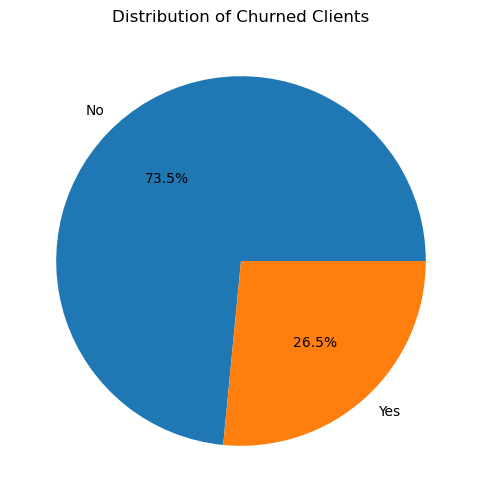

In [26]:
# Count the occurrences of each class in the Churned column
churned_value_counts = df['Churned'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(churned_value_counts, labels=churned_value_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Churned Clients')
plt.show()

The Churned variable exhibits a significant imbalance, with a larger proportion of customers not churning compared to those who do. Specifically, approximately 26.5% of clients in the dataset have churned, while 73.5% have remained with the service. This disparity is an important consideration as we proceed with our analysis and model building, as it may impact the performance of our models.

### Categorical Features Analysis

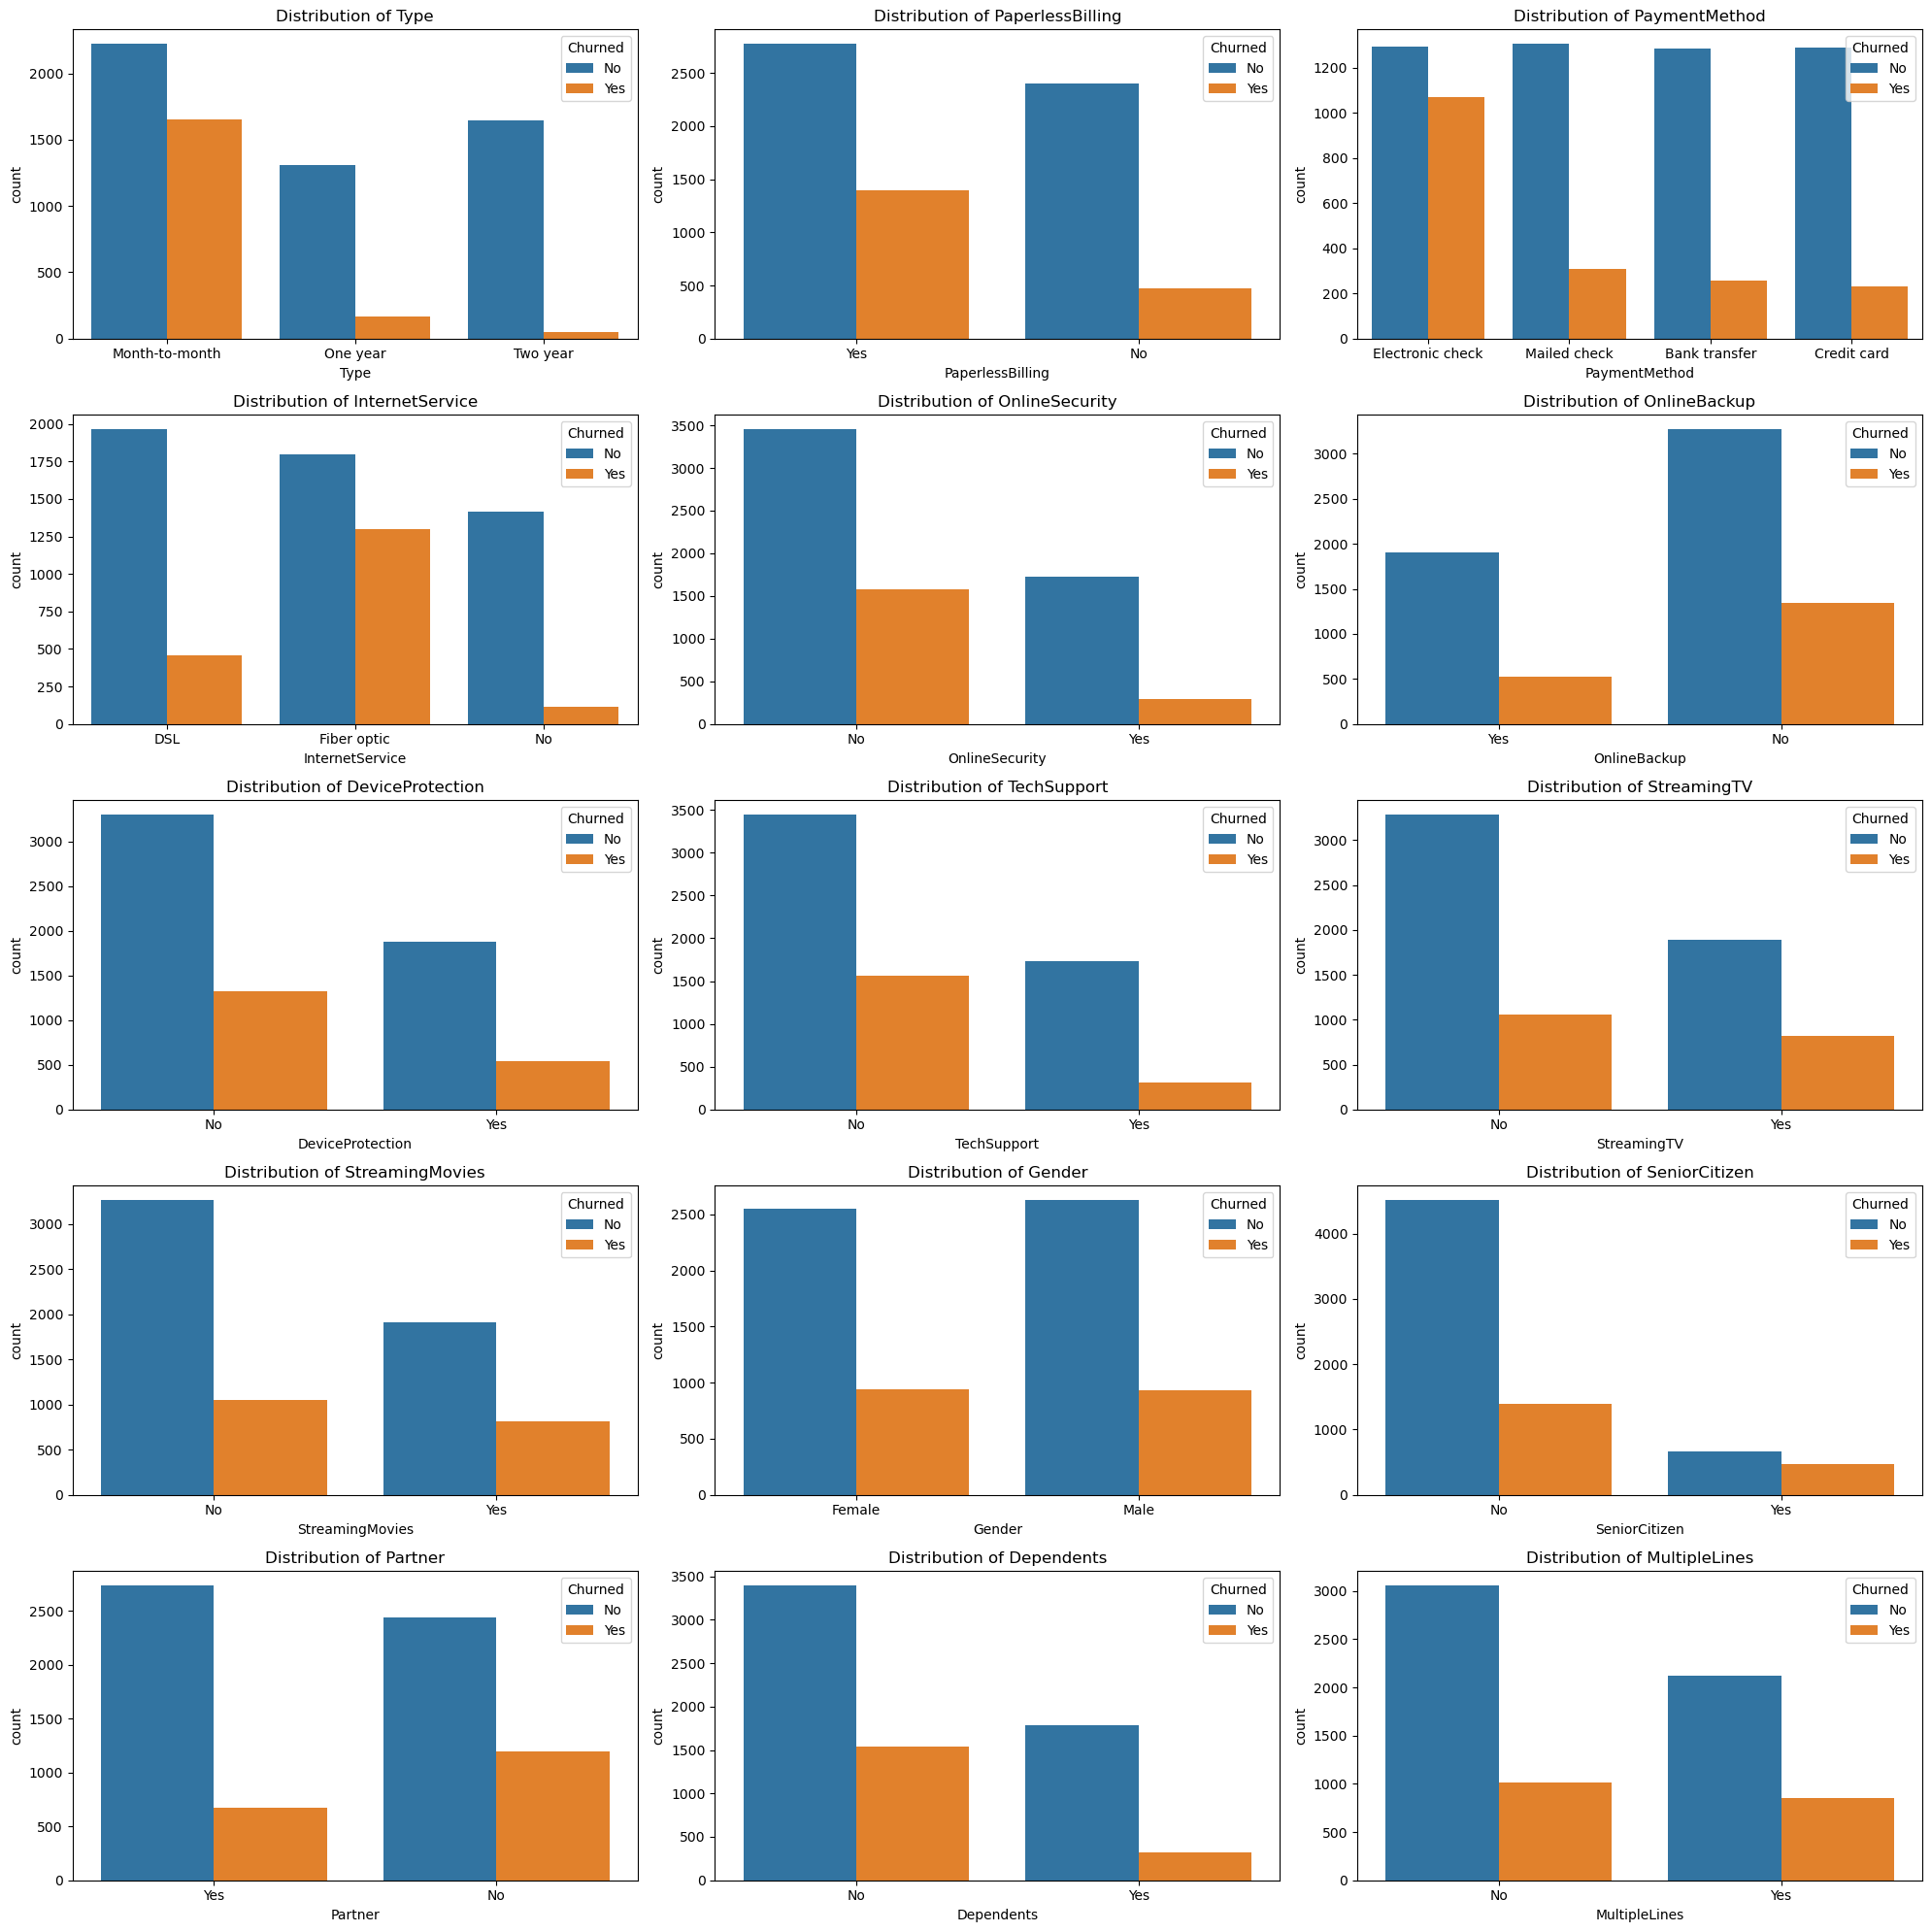

In [27]:
# Select categorical columns of object data type, excluding 'customerID' and 'Churned'
object_columns = df.select_dtypes(include='object').columns
object_columns = object_columns.drop(['customerID', 'Churned'], errors='ignore')

# Number of object columns
num_plots = len(object_columns)

# Create subplots (e.g., 5 rows and 3 columns for 15 plots)
rows = 5
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each object column and create a countplot
for i, col in enumerate(object_columns):
    sns.countplot(data=df, x=col, ax=axes[i], hue='Churned')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x')

# Adjust the layout
plt.tight_layout()
plt.show()

From the array of bar plots above we can identify three key features—Contract Type, Payment Method, and Internet Service—where churn rates are notably higher for specific groups compared to others within each category. These features emerge as the most significant predictors of whether a customer is likely to discontinue their service.

**Type of Contract:** Customers on month-to-month plans have a significantly higher churn rate due to the flexibility and short-term commitment, while those on one- or two-year contracts show greater loyalty, likely because of the longer-term investment.

**Payment Method:** Customers using electronic checks churn more frequently, possibly due to payment-related issues like processing delays or errors, making this a key area to address for improving customer retention.

**Internet Service:** Fiber optic users exhibit higher churn rates, potentially driven by service disruptions or unmet speed expectations, highlighting the need for consistent performance and strong technical support to reduce churn.

### Numerical Features Analysis

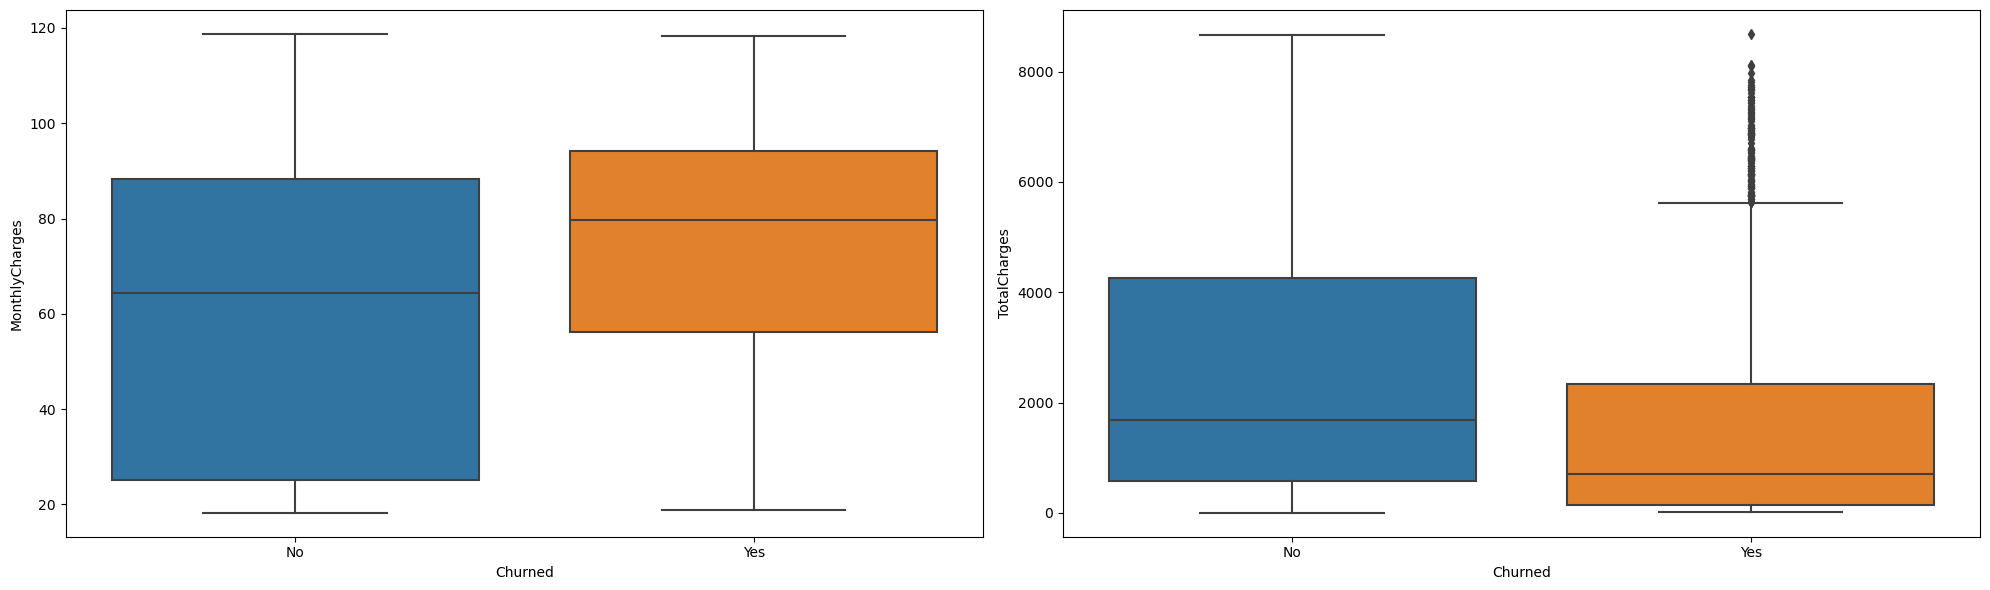

In [28]:
# List of numerical columns to plot
numerical_cols = ['MonthlyCharges', 'TotalCharges']

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

# Create box plots
for ax, col in zip(axes.flatten(), numerical_cols):
    sns.boxplot(data=df, y=col, x='Churned', ax=ax)

# Adjust the layout
plt.tight_layout()
plt.show()

The box plots above, illustrating the distribution of churned clients across the numerical features MonthlyCharges and TotalCharges, provide valuable insights into customer behavior and churn patterns.

**Monthly Charges:** Customers who churn tend to have higher monthly charges compared to those who remain, indicating that cost may be a significant factor in their decision to leave.

**Total Charges:** Customers who churn generally have lower total charges compared to those who stay, likely because they discontinue the service before accumulating substantial charges over time.

### Client Longevity Analysis

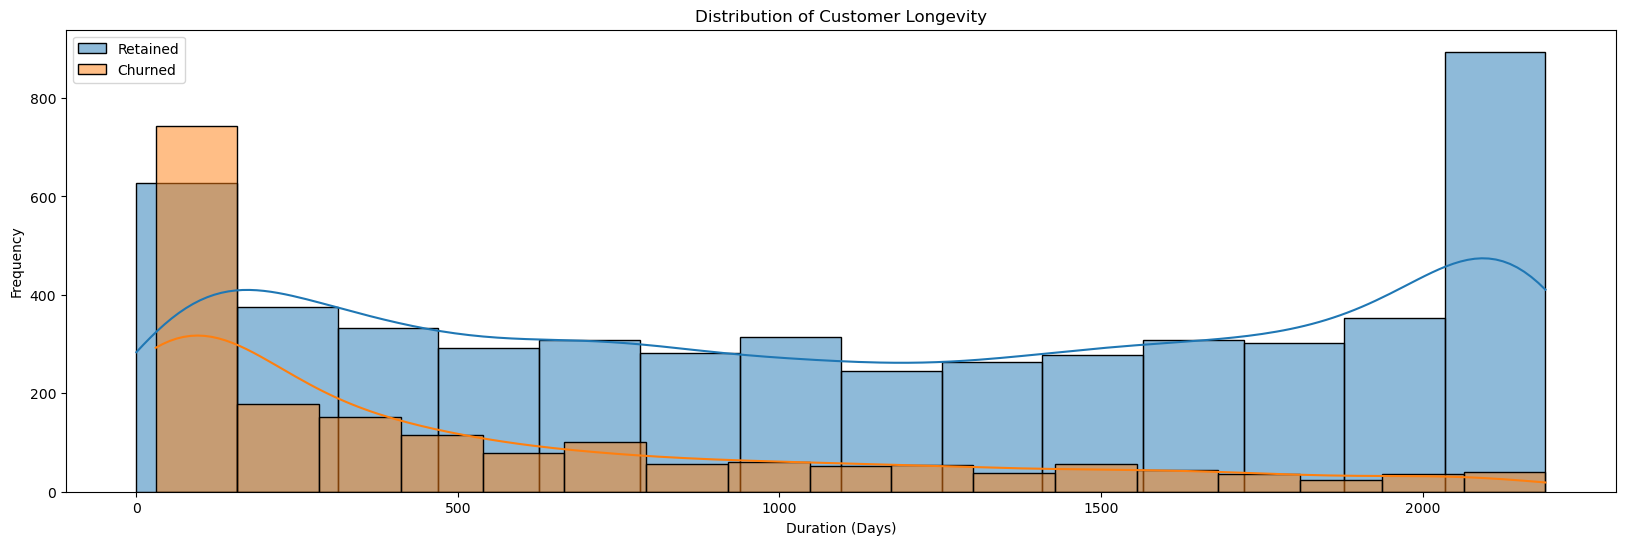

In [29]:
# Set the size of the plot
plt.figure(figsize=(20, 6))

# Create a distribution plot for longevity of customers who did not churn
sns.histplot(df[df['Churned'] == 'No']['Duration(Days)'], kde=True, label='Retained')

# Create a distribution plot for longevity of customers who churned
sns.histplot(df[df['Churned'] == 'Yes']['Duration(Days)'], kde=True, label='Churned')

# Set title and labels
plt.title('Distribution of Customer Longevity')
plt.xlabel('Duration (Days)')
plt.ylabel('Frequency')

# Show legend
plt.legend()

# Display the plot
plt.show()

As we can see from the visual above, churned customers tend to have shorter tenures, often leaving the service shortly after joining. In contrast, retained customers show a more uniform distribution of longevity, with peaks at certain intervals, indicating they stay with the service for longer periods. This suggests that longevity could be a valuable predictor of churn, as the distribution patterns differ notably between churned and retained customers.

## Model Training Prep

We will now prepare the data for model training, starting by mapping the "Yes" and "No" values in the Churned target column to numerical values, where "Yes" will be mapped to 1 and "No" to 0.

We so do this because most machine learning algorithms require numerical input to process the data. Algorithms can't work directly with categorical values like "Yes" and "No," so we map them to 1 and 0 to make the data suitable for analysis. This transformation allows the model to interpret and learn from the data to make accurate predictions.

In [30]:
# Replace categorical values in the Churned column with numerical representations for easier processing
df['Churned'] = df['Churned'].replace('No', 0)
df['Churned'] = df['Churned'].replace('Yes', 1)

print(df['Churned'].value_counts())

0    5174
1    1869
Name: Churned, dtype: int64


As mentioned during the exploratory data analysis, there is a significant class imbalance between churned (1) and non-churned (0) clients in the target column. To address this imbalance, we will handle it carefully when training our models, ensuring proper hyperparameter tuning without distorting the evaluation metrics.

### Data Splitting

We will now split the data into training (60%), validation (20%), and test (20%) sets. This 3:1:1 ratio accounts for the fact that the test data is derived from the same source. If the test data were separate, we would only need to split the source data into training and validation sets, with the validation set comprising 25% of the source data to maintain a similar split ratio.

In [31]:
# Extract the feature variables
features = df.drop(['customerID', 'Churned', 'BeginDate', 'EndDate'], axis=1)

# Extract the target variable 'Churned'
target = df['Churned']

# Split data: 60% for training, 20% for validation, and 20% for testing
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=12345)

# Further split the remaining 40% into validation (20%) and test (20%) sets
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=12345)

# Print the size of each dataset
print('Training Features Size:', features_train.shape)
print()
print('Validation Features Size:', features_valid.shape)
print()
print('Test Features Size:', features_test.shape)

Training Features Size: (4225, 18)

Validation Features Size: (1409, 18)

Test Features Size: (1409, 18)


With the data split correctly, we will now encode our categorical features using two methods. For the Random Forest and XGBoost models, we will use label encoding, which effectively converts categories into ordinal values suitable for these algorithms. For the Logistic Regression model, we will apply one-hot encoding, as it converts categorical variables into binary features and is well-suited for linear models. The CatBoost and LightGBM models handle categorical variables internally, so no additional encoding is required for these models. This approach ensures that each model is trained with the most appropriate encoding method for its specific requirements.

We will explicitly define our categorical features to streamline the encoding process.

In [32]:
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod',
                        'InternetService', 'OnlineSecurity', 'OnlineBackup',
                        'DeviceProtection', 'TechSupport', 'StreamingTV',
                        'StreamingMovies', 'Gender', 'SeniorCitizen',
                        'Partner', 'Dependents', 'MultipleLines']

### Label Encoding

In [33]:
# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit and transform on training features
features_train_encoded = features_train.copy()
features_train_encoded[categorical_features] = ordinal_encoder.fit_transform(features_train[categorical_features])

# Fit and transform validation features
features_valid_encoded = features_valid.copy()
features_valid_encoded[categorical_features] = ordinal_encoder.transform(features_valid[categorical_features])

# Fit and transform test features
features_test_encoded = features_test.copy()
features_test_encoded[categorical_features] = ordinal_encoder.transform(features_test[categorical_features])

# Print the size of each dataset after label encoding
print('Training Features Size (Label Encoded):', features_train_encoded.shape)
print()
print('Validation Features Size (Label Encoded):', features_valid_encoded.shape)
print()
print('Test Features Size (Label Encoded):', features_test_encoded.shape)

Training Features Size (Label Encoded): (4225, 18)

Validation Features Size (Label Encoded): (1409, 18)

Test Features Size (Label Encoded): (1409, 18)


The training data has been successfully label encoded.

### One-Hot Encoding

In [34]:
# Initialize the OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')

# Fit the encoder on the training data and transform training features
features_train_ohe = ohe.fit_transform(features_train[categorical_features])

# Transform validation and test features using the same encoder
features_valid_ohe = ohe.transform(features_valid[categorical_features])
features_test_ohe = ohe.transform(features_test[categorical_features])

# Convert the result to a DataFrame
features_train_ohe = pd.DataFrame(features_train_ohe, columns=ohe.get_feature_names_out(categorical_features))
features_valid_ohe = pd.DataFrame(features_valid_ohe, columns=ohe.get_feature_names_out(categorical_features))
features_test_ohe = pd.DataFrame(features_test_ohe, columns=ohe.get_feature_names_out(categorical_features))

# Print the size of each dataset after one-hot encoding
print('Training Features Size (One-Hot Encoded):', features_train_ohe.shape)
print()
print('Validation Features Size (One-Hot Encoded):', features_valid_ohe.shape)
print()
print('Test Features Size (One-Hot Encoded):', features_test_ohe.shape)

Training Features Size (One-Hot Encoded): (4225, 19)

Validation Features Size (One-Hot Encoded): (1409, 19)

Test Features Size (One-Hot Encoded): (1409, 19)


The training data has been successfully one-hot encoded.

## Model Training

For model training, our focus will be on evaluating the AUC-ROC, Accuracy, and F1 scores across various machine learning models with  hyperparameter tuning. To streamline this repetitive process, I have developed a function designed to expedite and simplify the evaluation.

The function below assesses a machine learning model by calculating key performance metrics. It  computes the AUC-ROC, Accuracy, and F1 scores on the validation set, as well as plots the ROC curve. By printing and returning these metrics, the function aids in analyzing the efficiency and effectiveness of the model.

In [35]:
# Model evaluation function
def model_eval(model, features_train, features_valid, target_train, target_valid):
    
    # Train the model on the training data
    model.fit(features_train, target_train)

    # Generate predictions on the validation set
    predictions = model.predict(features_valid)
    probabilities_test = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_test[:, 1]

    # Calculate the AUC-ROC, Accuracy and F1 scores of the predictions
    aucroc = roc_auc_score(target_valid, probabilities_one_valid)
    accuracy = accuracy_score(target_valid, predictions)
    f1 = f1_score(target_valid, predictions)

    # Print out the AUC-ROC, Accuracy and F1 scores
    print("AUC-ROC:", aucroc)
    print("Accuracy:", accuracy)
    print("F1:", f1)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], linestyle='--')  # ROC curve for random model
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()

    # Return AUC-ROC, Accuracy and F1 scores
    return aucroc, accuracy, f1

### Logistic Regression

We will start with a Logistic Regression model. Logistic regression serves as a valuable benchmark for assessing other methods. For example, if gradient boosting underperforms compared to logistic regression, it indicates that there may be an issue with the implementation or configuration of the gradient boosting model.

Note: Train with one-hot encoded data

LOGISTIC REGRESSION STATS:
--------------------------
AUC-ROC: 0.8327360226757139
Accuracy: 0.7792760823278921
F1: 0.5550786838340486


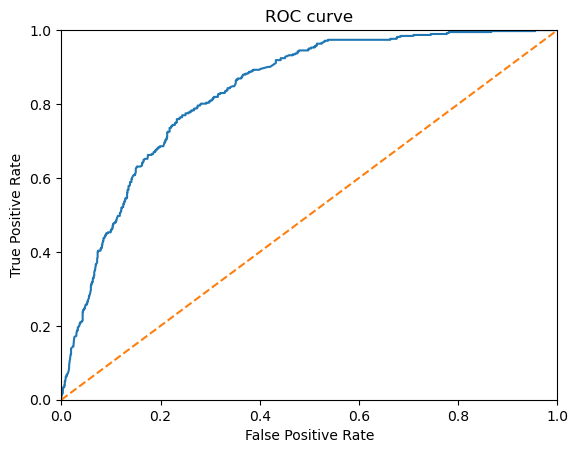

In [36]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(solver='liblinear', random_state=12345)

print("LOGISTIC REGRESSION STATS:")
print("--------------------------")

# Evaluate the Logistic Regression model
lr_aucroc, lr_accuracy, lr_f1, = model_eval(lr_model, features_train_ohe, features_valid_ohe, target_train, target_valid)

### Random Forest

Note: Train with label encoded data

BEST RANDOM FOREST HYPERPARAMETERS: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}

RANDOM FOREST STATS:
--------------------
AUC-ROC: 0.8626087776627904
Accuracy: 0.8190205819730305
F1: 0.6130500758725341


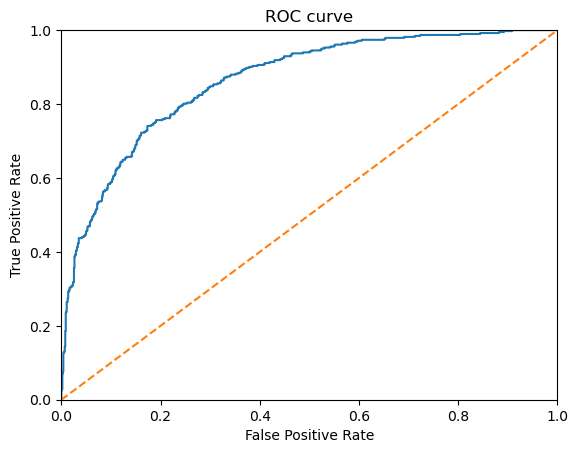

In [37]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=12345)

# Set up RandomizedSearchCV for tuning the Random Forest model
rf_random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions={'n_estimators': [10, 50, 100, 200], 
                         'max_features': ['sqrt', 'log2'],
                         'max_depth': [None, 10, 20, 30, 40],
                         'min_samples_split': [2, 5, 10], 
                         'min_samples_leaf': [1, 2, 4]}, 
    n_iter=10,     
    cv=5,                        
    scoring='roc_auc',
    n_jobs=-1,                      
    random_state=12345
)

# Fit the RandomizedSearchCV object to the training data
rf_random_search.fit(features_train_encoded, target_train)

print("BEST RANDOM FOREST HYPERPARAMETERS:", rf_random_search.best_params_)
print()

# Get the best Random Forest model from the search
tuned_rf_model = rf_random_search.best_estimator_

print("RANDOM FOREST STATS:")
print("--------------------")

# Evaluate the tuned Random Forest model
rf_aucroc, rf_accuracy, rf_f1 = model_eval(tuned_rf_model, features_train_encoded, features_valid_encoded, target_train, target_valid)

### LightGBM

LightGBM can handle categorical features natively. By converting them to the category dtype, we are signaling to LightGBM that these features are categorical. This allows the algorithm to use its internal optimizations for processing such data, which can lead to more efficient training and potentially better performance.

BEST LIGHTGBM HYPERPARAMETERS: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 50, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6}

LIGHTGBM STATS:
---------------
AUC-ROC: 0.8974813542213635
Accuracy: 0.850958126330731
F1: 0.7000000000000001


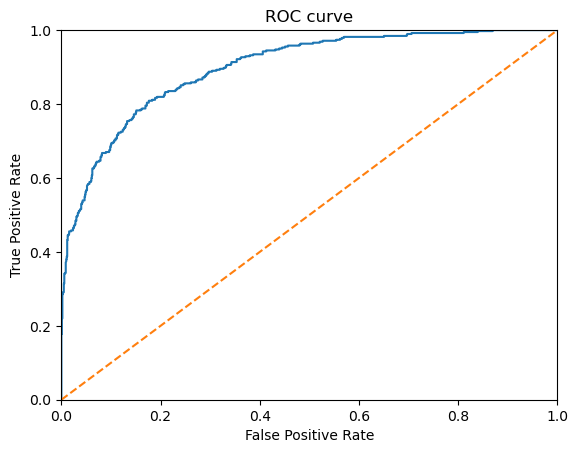

In [38]:
# Create copies of the training, validation, and test feature datasets
features_train_cat = features_train.copy()
features_valid_cat = features_valid.copy()
features_test_cat = features_test.copy()

# Convert categorical features to 'category' dtype for all datasets
for feature in categorical_features:
    features_train_cat[feature] = features_train[feature].astype('category')
    features_valid_cat[feature] = features_valid[feature].astype('category')
    features_test_cat[feature] = features_test[feature].astype('category')

# Initialize the LightGBM model
lgbm_model = LGBMClassifier(random_state=12345, verbose=-1)

# Set up RandomizedSearchCV for tuning the LightGBM model
lgbm_random_search = RandomizedSearchCV(
    lgbm_model, 
    param_distributions={'num_leaves': [31, 50, 70],
                         'max_depth': [-1, 10, 20, 30],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'n_estimators': [50, 100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0],
                         'colsample_bytree': [0.6, 0.8, 1.0],
                         'reg_alpha': [0, 0.1, 0.5, 1],
                         'reg_lambda': [0, 0.1, 0.5, 1]}, 
    n_iter=10,     
    cv=5,                        
    scoring='roc_auc',
    n_jobs=-1,                      
    random_state=12345
)

# Fit the RandomizedSearchCV object to the training data
lgbm_random_search.fit(features_train_cat, target_train)

print("BEST LIGHTGBM HYPERPARAMETERS:", lgbm_random_search.best_params_)
print()

# Get the best LightGBM model from the search
tuned_lgbm_model = lgbm_random_search.best_estimator_

print("LIGHTGBM STATS:")
print("---------------")

# Evaluate the tuned LightGBM model
lgbm_aucroc, lgbm_accuracy, lgbm_f1 = model_eval(tuned_lgbm_model, features_train_cat, features_valid_cat, target_train, target_valid)

### CatBoost

CatBoost is specifically optimized for handling categorical features with high efficiency. By explicitly specifying these features in the parameters, we enable CatBoost to apply its advanced algorithms designed for categorical data. This eliminates the need for manual encoding and ensures that the model processes categorical features effectively, leading to improved performance and accuracy.

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


BEST CATBOOST HYPERPARAMETERS: {'random_strength': 1, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 6, 'border_count': 100, 'bagging_temperature': 0}

CATBOOST STATS:
---------------
AUC-ROC: 0.8713250100684657
Accuracy: 0.8161816891412349
F1: 0.606980273141123


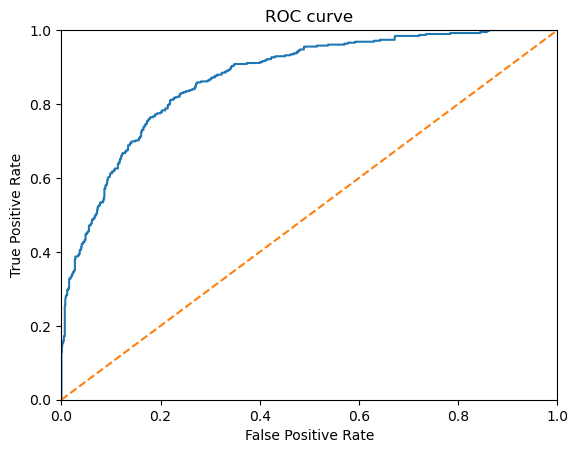

In [39]:
# Initialize the CatBoost model
cb_model = CatBoostClassifier(random_state=12345, cat_features=categorical_features, verbose=False)

# Set up RandomizedSearchCV for tuning the CatBoost model
cb_random_search = RandomizedSearchCV(
    cb_model, 
    param_distributions={'depth': [6, 8, 10, 12],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'iterations': [100, 200, 300, 500],
                         'l2_leaf_reg': [1, 3, 5, 10],
                         'border_count': [32, 50, 100],
                         'bagging_temperature': [0, 0.5, 1],
                         'random_strength': [0, 1, 2, 3]}, 
    n_iter=10,                 
    cv=5,                        
    scoring='neg_root_mean_squared_error',  
    n_jobs=-1,                   
    random_state=12345
)

# Fit the RandomizedSearchCV object to the training data
cb_random_search.fit(features_train, target_train)

print("BEST CATBOOST HYPERPARAMETERS:", cb_random_search.best_params_)
print()

# Get the best CatBoost model from the search
tuned_cb_model = cb_random_search.best_estimator_

print("CATBOOST STATS:")
print("---------------")

# Evaluate the tuned CatBoost model
cb_aucroc, cb_accuracy, cb_f1 = model_eval(tuned_cb_model, features_train, features_valid, target_train, target_valid)

### XGBoost

Note: Train with label encoded data

BEST XGBOOST HYPERPARAMETERS: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.8}

XGBOOST STATS:
--------------
AUC-ROC: 0.8830159005286581
Accuracy: 0.829666430092264
F1: 0.6571428571428573


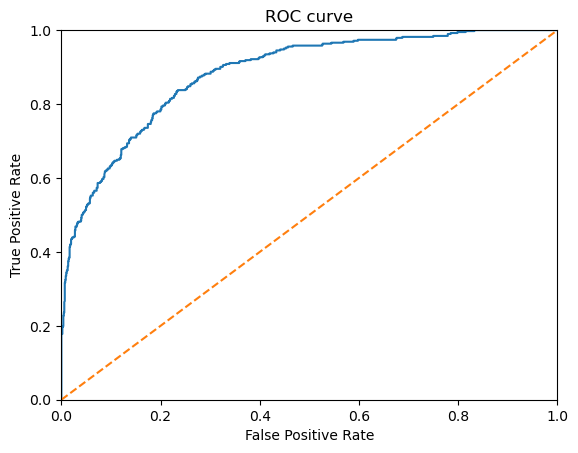

In [40]:
# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=12345)

# Set up RandomizedSearchCV for tuning the XGBoost model
xgb_random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions={'n_estimators': [50, 100, 200, 300],
                         'max_depth': [3, 5, 7, 10],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'subsample': [0.6, 0.8, 1.0],
                         'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.5, 1],
                         'reg_alpha': [0, 0.1, 0.5, 1],
                         'reg_lambda': [0, 0.1, 0.5, 1]}, 
    n_iter=10,                      
    cv=5,                      
    scoring='roc_auc', 
    n_jobs=-1,                     
    random_state=12345
)

# Fit the RandomizedSearchCV object to the training data
xgb_random_search.fit(features_train_encoded, target_train)

print("BEST XGBOOST HYPERPARAMETERS:", xgb_random_search.best_params_)
print()

# Get the best XGBoost model from the search
tuned_xgb_model = xgb_random_search.best_estimator_

print("XGBOOST STATS:")
print("--------------")

# Evaluate the tuned XGBoost model
xgb_aucroc, xgb_accuracy, xgb_f1 = model_eval(tuned_xgb_model, features_train_encoded, features_valid_encoded, target_train, target_valid)

## Model Analysis & Test

Having trained and validated all our models using the validation set, we will now analyze their performance to identify which model will be most beneficial for Interconnect. To facilitate comparison and draw conclusions, we will compile their statistics into a single data frame. This will make it easier to evaluate and compare the models' effectiveness.

In [41]:
model_analysis = pd.DataFrame({'Model': ['Logistic Regression',
                                         'Random Forest',
                                         'LightGBM',
                                         'CatBoost',
                                         'XGBoost'],

                                'AUC-ROC': [lr_aucroc,
                                            rf_aucroc, 
                                            lgbm_aucroc, 
                                            cb_aucroc,
                                            xgb_aucroc],
                                
                                'Accuracy': [lr_accuracy,
                                             rf_accuracy, 
                                             lgbm_accuracy, 
                                             cb_accuracy,
                                             xgb_accuracy],
                                
                                'F1': [lr_f1,
                                       rf_f1, 
                                       lgbm_f1, 
                                       cb_f1,
                                       xgb_f1]})

display(model_analysis.sort_values(by='AUC-ROC', ascending=False))

,Model,AUC-ROC,Accuracy,F1
2,LightGBM,0.897481,0.850958,0.700000
4,XGBoost,0.883016,0.829666,0.657143
3,CatBoost,0.871325,0.816182,0.606980
1,Random Forest,0.862609,0.819021,0.613050
0,Logistic Regression,0.832736,0.779276,0.555079


**Logistic Regression** shows a moderate level of effectiveness with an AUC-ROC score of 0.832736, indicating that it can discriminate reasonably well between churned and retained clients. The accuracy score of 0.779276 reflects that about 78% of predictions made by the model are correct. However, the F1 score of 0.555079 suggests that while the model is accurate, it struggles with class imbalance, likely leading to lower precision or recall when identifying churned clients. This could indicate that the model might miss many instances of churn, making it less reliable for practical applications.

**Random Forest** exhibits similar performance to Logistic Regression, with an AUC-ROC of 0.862609 and an accuracy of 0.819021, which is higher than that of Logistic Regression. This suggests that Random Forest may be better at generalizing to unseen data, improving overall prediction accuracy. However, its F1 score of 0.613050 is still on the lower side, indicating potential difficulties in correctly identifying the minority class (churned clients). This model also benefits from ensemble methods that help mitigate overfitting, but further tuning may be necessary to enhance its ability to manage class imbalance.

**LightGBM** stands out as the top performer among all models, achieving an AUC-ROC score of 0.897481, an accuracy of 0.850958, and an F1 score of 0.7. This indicates that LightGBM not only effectively distinguishes between churned and retained clients but also maintains a good balance between precision and recall. The model's efficiency in handling large datasets and its ability to learn complex patterns make it particularly suited for this task. Its superior performance suggests that it may be the most reliable option for predicting customer churn in practical applications.

**CatBoost** offers a solid performance with an AUC-ROC of 0.871325 and an accuracy of 0.816182. While these scores are competitive, the model has the lowest F1 score at 0.606980, indicating challenges in accurately identifying churned clients. This lower F1 score suggests that CatBoost may struggle with either precision or recall, potentially leading to a higher rate of false negatives. Despite its overall good accuracy, this could limit its effectiveness in real-world scenarios where accurately predicting churn is crucial.

**XGBoost** demonstrates a strong performance with an AUC-ROC score of 0.883016, indicating strong discriminatory power between churned and retained clients. Its accuracy of 0.829666 suggests that the model is capable of making correct predictions about 83% of the time. The F1 score of 0.657143, while lower than that of LightGBM, still reflects a decent balance between precision and recall. However, this score indicates that XGBoost may miss some churn cases or incorrectly predict churn in retained clients, though it still performs better than several other models when dealing with class imbalance.

In summary, LightGBM emerges as the best-performing model across all metrics, demonstrating strong capabilities in both distinguishing between churned and retained clients and managing class imbalance effectively. We will use this model to perform our final test.

FINAL LGBM STATS:
-----------------
AUC-ROC: 0.8932758978722541
Accuracy: 0.8481192334989354
F1: 0.6862170087976539


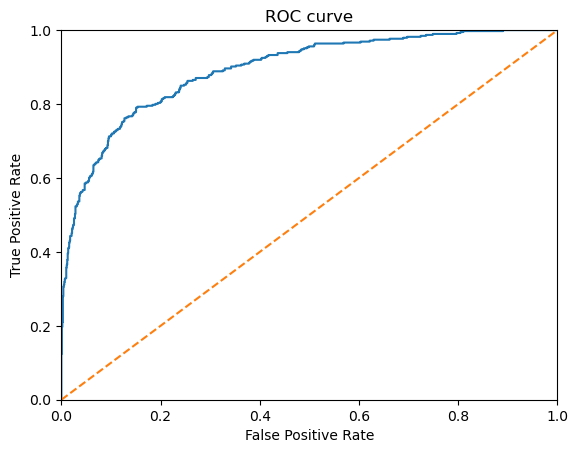

In [42]:
# Generate predictions on the test set
final_predictions = tuned_lgbm_model.predict(features_test_cat)
final_probabilities_test = tuned_lgbm_model.predict_proba(features_test_cat)
final_probabilities_one_valid = final_probabilities_test[:, 1]

# Calculate the AUC-ROC, Accuracy and F1 scores of the predictions
final_lgbm_aucroc = roc_auc_score(target_test, final_probabilities_one_valid)
final_lgbm_accuracy = accuracy_score(target_test, final_predictions)
final_lgbm_f1 = f1_score(target_test, final_predictions)

# Print out the AUC-ROC, Accuracy and F1 scores
print("FINAL LGBM STATS:")
print("-----------------")
print("AUC-ROC:", final_lgbm_aucroc)
print("Accuracy:", final_lgbm_accuracy)
print("F1:", final_lgbm_f1)

# Compute ROC curve
final_fpr, final_tpr, final_thresholds = roc_curve(target_test, final_probabilities_one_valid)

# Plot ROC curve
plt.figure()
plt.plot(final_fpr, final_tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--')  # ROC curve for random model
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

## Solution Report

In this project, we developed a robust machine learning framework to predict client churn for Interconnect, a leading telecom operator. The primary goal was to identify at-risk customers to implement effective retention strategies.

### Steps Performed
The following steps of the planned workflow were executed:

**A) Initialization:** We successfully imported necessary libraries, including Pandas, NumPy, Matplotlib, Seaborn for data manipulation and visualization, and Scikit-learn for model building.

**B) Load Data:** All four CSV files (contract.csv, personal.csv, internet.csv, phone.csv) were loaded into separate DataFrames. We ensured that the data types were appropriate for analysis.

**C) Data Preprocessing:**
- We checked for missing values and filled or dropped them as necessary.
- Duplicate rows were identified and removed.
- Inappropriate data types were converted to the correct format, ensuring consistency across the dataset.

**D) Exploratory Data Analysis:**
- Various visualizations (bar plots, histograms, box plots) were employed to identify trends and relationships between customer attributes and churn rates.
- Correlations between features and the target variable were explored to better understand the factors influencing churn.

**E) Model Training Preparation:**
- The dataset was split into training, validation, and test sets.
- Categorical variables were encoded using one-hot encoding to prepare the data for model training.
- Did not handle class imbalance through upsampling/downsampling to maintain the integrity of the original task and ensure that the validation and test sets remained representative.

**F) Model Training:**
- We selected a variety of classification algorithms, including Logistic Regression, Random Forest, XGBoost, CatBoost, and LightGBM.
- Cross-validation was used to evaluate model performance based on the AUC-ROC score, employing hyperparameter tuning with RandomizedSearchCV.

**G) Model Analysis & Test:**
- The performance of each model was analyzed using AUC-ROC and accuracy metrics.
- LightGBM emerged as the best-performing model, which was then retrained on the entire training set and evaluated on the test set.

### Difficulties Encountered and Solutions
One of the key challenges encountered was the significant class imbalance within the target variable (churn status). This imbalance could lead to models that predict the majority class more accurately while underperforming on the minority class (churned clients). To address this, we focused on selecting models that inherently manage class imbalance effectively, such as LightGBM. Additionally, thorough exploratory analysis helped us understand the features contributing to churn, allowing for more informed model selection and evaluation.

### Key Steps to Solving the Task
**1) In-depth Exploratory Analysis:** Understanding the factors influencing churn helped in feature selection and shaping retention strategies.

**2) Model Selection and Evaluation:** Choosing LightGBM based on its performance metrics and suitability for the dataset significantly impacted our results.

**3) Identifying Actionable Insights:** The analysis revealed critical patterns that can directly inform Interconnect’s retention strategies.

### Final Model and Quality Score
The final model chosen for predicting client churn was LightGBM. It achieved impressive performance metrics:

- **AUC-ROC:** 0.8933
- **Accuracy:** 84.81%
- **F1 Score:** 0.6862

These results underscore the model's capability to effectively distinguish between churned and retained clients, making it a valuable tool for identifying those at risk of leaving.

### Conclusion
The high accuracy and reasonable F1 score indicate strong overall performance, though there remains an opportunity to enhance sensitivity to minimize false negatives—those at-risk clients that may go undetected. This insight is pivotal for Interconnect as it directs retention strategies toward the most vulnerable customer segments.

By strategically focusing on identified factors influencing client churn—such as contract type, payment method, internet service usage, and overall charges—Interconnect can tailor its offerings to meet the diverse needs of its clients. This targeted approach will not only help mitigate churn rates but also empower the company to maintain a competitive edge in the telecom industry, ensuring sustained customer loyalty and satisfaction.




